## Loading the dataset

In [1]:
import pandas as pd
df = pd.read_csv("./day_month.csv")
df.head()

,production,p_per_m2,p_max,panel_area,facade_area,total_panel_area,exploitation_ratio,air_temp_mean,air_temp_max,clearsky_ghi_mean,...,relative_humidity_max,surface_pressure_mean,surface_pressure_min,surface_pressure_max,wind_direction_100m_mean,wind_direction_100m_min,wind_direction_100m_max,wind_speed_100m_mean,wind_speed_100m_min,wind_speed_100m_max
0,8.075,143.0,210.0,1.72,218.0,94.6,0.434,4.063830,6.50,61.673648,...,95.675,1025.209907,1023.175,1027.325,210.491356,114.25,281.5,3.281959,1.625,5.025
1,0.700,143.0,210.0,1.72,218.0,94.6,0.434,4.221410,5.00,61.055629,...,95.350,1029.553147,1027.750,1031.600,221.406250,115.00,273.0,3.476042,1.650,5.000
2,1.325,143.0,210.0,1.72,218.0,94.6,0.434,6.932292,8.75,89.687500,...,92.875,1004.979167,1002.000,1009.450,202.578125,153.50,255.0,6.997396,5.025,9.425
3,1.300,143.0,210.0,1.72,218.0,94.6,0.434,5.822917,7.50,89.614583,...,92.700,1004.126042,1000.750,1010.600,216.354167,181.50,259.0,7.590625,5.450,9.650
4,18.250,143.0,210.0,1.72,218.0,94.6,0.434,6.647368,11.50,154.226316,...,85.625,1019.062632,1016.375,1021.425,154.531579,123.00,190.0,5.128947,3.625,7.500


## Preoaring the (x,y) pairs

### Scaling the data

In [2]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)

### Creating windows

In [3]:
production_column = 'production'

def get_target_column_index(df, target_column):
    for i, column in enumerate(df.columns):
        if column == target_column:
            return i

    return -1

In [4]:
import numpy as np

def get_windows(data, window_size=10):
    x = []
    y = []

    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i])
        y.append(data[i][get_target_column_index(df, production_column)])

    return np.array(x), np.array(y)

In [5]:
window_size = 2*12  # 2*1h window
x, y = get_windows(data_scaled, window_size=window_size)

x.shape, y.shape

((6562, 24, 34), (6562,))

### Splitting the data

In [6]:
train_split_index = int(0.8 * len(df))
test_split_index = int(0.9 * len(df))

x_train, y_train = x[:train_split_index], y[:train_split_index]
x_test, y_test = x[train_split_index:test_split_index], y[train_split_index:test_split_index]
x_val, y_val = x[test_split_index:], y[test_split_index:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((5268, 24, 34), (5268,), (659, 24, 34), (659,), (635, 24, 34), (635,))

### Plotting the splits

In [7]:
import matplotlib.pyplot as plt


def plot_time_series(timesteps, values, label, format='-^', start=0, end=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("date")
    plt.ylabel("production")

    plt.legend(fontsize=14)
    plt.grid(True)

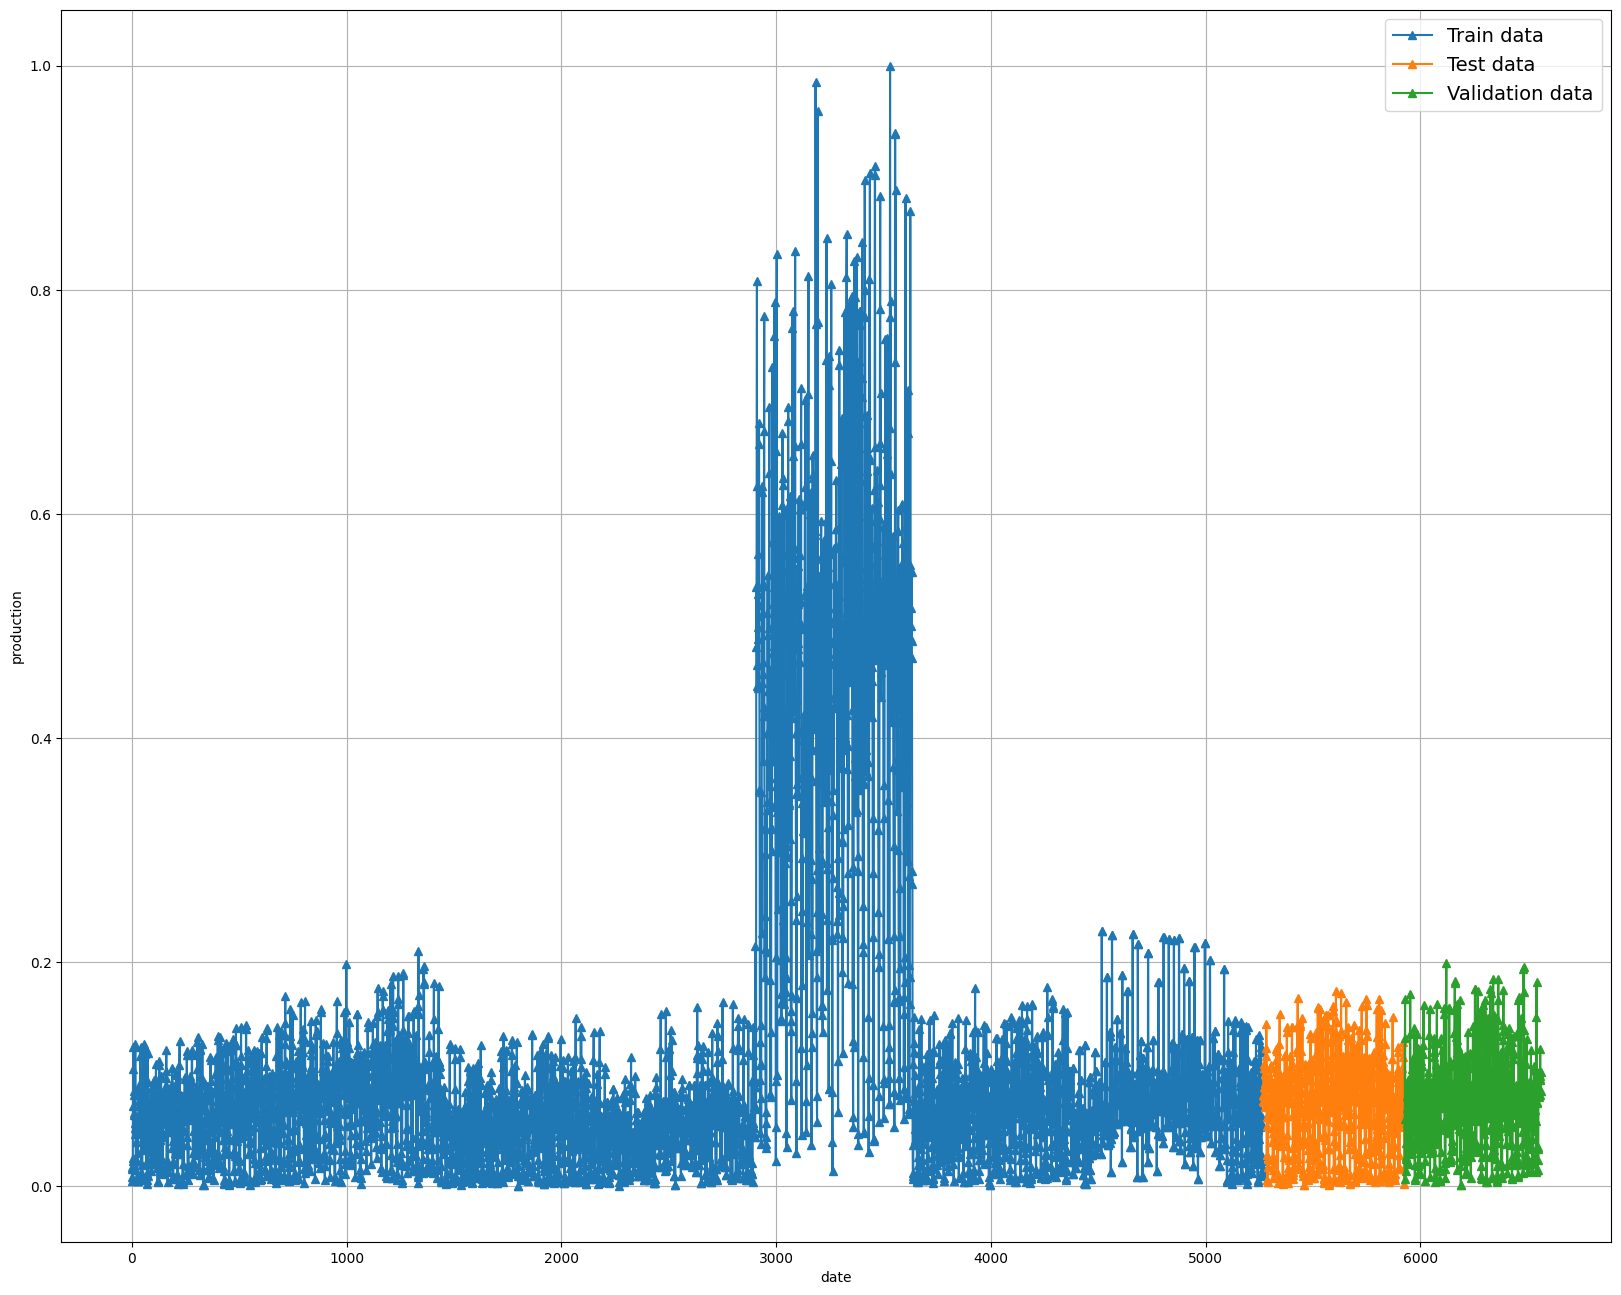

In [8]:
plt.figure(figsize=(20, 16))

timesteps = range(len(x_train))
plot_time_series(timesteps=timesteps, values=y_train, label="Train data")

timesteps = range(len(x_train), len(x_train) + len(x_test))
plot_time_series(timesteps=timesteps, values=y_test, label="Test data")

timesteps = range(len(x_train) + len(x_test),
                  len(x_train) + len(x_test) + len(x_val))
plot_time_series(timesteps=timesteps, values=y_val, label="Validation data")

### Preparing the performances metrics

In [9]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [10]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
    }

In [11]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()

    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)

    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    r2 = r2_score(y_true.numpy(), y_pred.numpy()) 

    return {
        "mae": mae,
        "mse": mse,
        "r2": r2
    }

## Modeling

In [12]:
import os
import tensorflow as tf

from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM1D, MaxPool1D, GlobalMaxPool1D, Conv1D, Conv2D
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

### Plotting the loss

In [13]:
def plot_loss(history):
    plt.figure(figsize=(20, 8))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Creating callbacks

In [14]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)


def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

### Utils function

In [15]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

## ConvLSTM

#### Preparing the model

In [16]:
x_train_conv_lstm = np.expand_dims(x_train, axis=2)
x_val_conv_lstm = np.expand_dims(x_val, axis=2)
x_test_conv_lstm = np.expand_dims(x_test, axis=2)

print(f"{x_train.shape} -> {x_train_conv_lstm.shape}")

(5268, 24, 34) -> (5268, 24, 1, 34)


In [17]:
from tensorflow.keras.layers import ConvLSTM1D, Flatten, Dense

# Hyperparamètres optimisés
filters = 64
kernel_size = 1
activation = 'relu'
dense_units = 128
learning_rate = 0.0036909175284319386

tf.random.set_seed(42)

input_shape = (x_train_conv_lstm.shape[1:])
conv_lstm_model = tf.keras.Sequential([
    ConvLSTM1D(filters=filters, kernel_size=(kernel_size,), activation=activation,
               return_sequences=True, input_shape=input_shape),
    ConvLSTM1D(filters=filters, kernel_size=(kernel_size,), activation=activation,
               return_sequences=False),
    Flatten(),
    Dense(units=dense_units, activation='relu'),
    Dense(1, activation="linear")
], name="model_conv_lstm.keras")

conv_lstm_model.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
)

conv_lstm_model.summary()

C:\Users\peesc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "model_conv_lstm.keras"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm1d (ConvLSTM1D)             │ (None, 24, 1, 64)           │          25,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm1d_1 (ConvLSTM1D)           │ (None, 1, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,817 (261.00 KB)

 Trainable params: 66,817 (261.00 KB)

 Non-trainable params: 0 (0.00 B)

#### Training the model convlstm

In [18]:
import os
import time
import logging
from codecarbon import EmissionsTracker


os.makedirs('emissions', exist_ok=True)

tracker_conv_lstm = EmissionsTracker(
    project_name="PEWH",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="emissions_conv_lstm.csv",
    output_dir='./emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon INFO @ 03:35:43] [setup] RAM Tracking...
[codecarbon INFO @ 03:35:43] [setup] CPU Tracking...
[codecarbon WARNING @ 03:35:43] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 03:35:45] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-9700K CPU @ 3.60GHz
[codecarbon INFO @ 03:35:45] [setup] GPU Tracking...
[codecarbon INFO @ 03:35:45] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 03:35:45] >>> Tracker's metadata:
[codecarbon INFO @ 03:35:45]   Platform system: Windows-10-10.0.19045-SP0
[codecarbon INFO @ 03:35:45]   Python version: 3.12.3
[codecarbon INFO @ 03:35:45]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 03:35:45]   Available RAM : 31.935 GB
[codecarbon INFO @ 03:35:45]   CPU count: 8
[codecarbon INFO @ 03:35:45]   CPU model: Intel(R) Core(TM) i7-9700K CPU @ 3.60GHz
[codecarbon INFO @ 03:35:45]   GPU count: 1
[codecarbon INFO @ 03:35:45]   GPU mo

In [19]:
def start_training_conv_lstm():
    start_time = time.time()
    conv_lstm_history = conv_lstm_model.fit(x=x_train_conv_lstm,
                                            y=y_train,
                                            epochs=300,
                                            verbose=1,
                                            batch_size=512,
                                            validation_data=(
                                                x_val_conv_lstm, y_val),
                                            callbacks=[create_model_checkpoint(model_name=conv_lstm_model.name)])
    training_duration = time.time() - start_time

    return conv_lstm_history, training_duration

In [ ]:
tracker_conv_lstm.start()
try:
    history_conv_lstm, training_duration_conv_lstm = start_training_conv_lstm()
finally:
    tracker_conv_lstm.stop()

Epoch 1/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 0.1388 - val_loss: 0.0414
Epoch 2/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0549 - val_loss: 0.0355
Epoch 3/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0507 - val_loss: 0.0372
Epoch 4/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0500 - val_loss: 0.0357
Epoch 5/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0479 - val_loss: 0.0310
Epoch 6/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0455 - val_loss: 0.0312
Epoch 7/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0445 - val_loss: 0.0311
Epoch 8/300
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0453

[codecarbon INFO @ 03:35:58] Energy consumed for RAM : 0.000033 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:35:58] Energy consumed for all CPUs : 0.000132 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:35:58] Energy consumed for all GPUs : 0.000073 kWh. Total GPU Power : 26.311583272535565 W
[codecarbon INFO @ 03:35:58] 0.000239 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0452 - val_loss: 0.0294
Epoch 9/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0432 - val_loss: 0.0295
Epoch 10/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0408 - val_loss: 0.0291
Epoch 11/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0398 - val_loss: 0.0276
Epoch 12/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0389 - val_loss: 0.0274
Epoch 13/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0386 - val_loss: 0.0282
Epoch 14/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0378 - val_loss: 0.0294
Epoch 15/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0367 - val_loss: 0.0283
Epoch 16/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0368 - val_loss: 0.0282
Epoch 17/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0361 - val_loss: 0.0294
Epoch 18/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0359 - val_loss: 0.0284
Epoch 19/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - lo

[codecarbon INFO @ 03:36:08] Energy consumed for RAM : 0.000067 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:36:08] Energy consumed for all CPUs : 0.000264 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:36:08] Energy consumed for all GPUs : 0.000151 kWh. Total GPU Power : 27.970993022182352 W
[codecarbon INFO @ 03:36:08] 0.000482 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0363 - val_loss: 0.0278
Epoch 23/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0355 - val_loss: 0.0266
Epoch 24/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0358 - val_loss: 0.0285
Epoch 25/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0352 - val_loss: 0.0288
Epoch 26/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0352 - val_loss: 0.0292
Epoch 27/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0358 - val_loss: 0.0278
Epoch 28/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0351 - val_loss: 0.0276
Epoch 29/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0347 - val_loss: 0.0273
Epoch 30/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0346 - val_loss: 0.0281
Epoch 31/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0348 - val_loss: 0.0278
Epoch 32/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0343 - val_loss: 0.0268
Epoch 33/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - l

[codecarbon INFO @ 03:36:18] Energy consumed for RAM : 0.000100 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:36:18] Energy consumed for all CPUs : 0.000396 kWh. Total CPU Power : 47.5 W


 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0350

[codecarbon INFO @ 03:36:18] Energy consumed for all GPUs : 0.000241 kWh. Total GPU Power : 32.39899652571067 W
[codecarbon INFO @ 03:36:18] 0.000737 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0351 - val_loss: 0.0282
Epoch 37/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0350 - val_loss: 0.0281
Epoch 38/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0354 - val_loss: 0.0272
Epoch 39/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0352 - val_loss: 0.0272
Epoch 40/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0341 - val_loss: 0.0262
Epoch 41/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0337 - val_loss: 0.0265
Epoch 42/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0336 - val_loss: 0.0263
Epoch 43/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0337 - val_loss: 0.0264
Epoch 44/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0333 - val_loss: 0.0260
Epoch 45/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0333 - val_loss: 0.0264
Epoch 46/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0334 - val_loss: 0.0269
Epoch 47/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - l

[codecarbon INFO @ 03:36:28] Energy consumed for RAM : 0.000133 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:36:28] Energy consumed for all CPUs : 0.000528 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:36:28] Energy consumed for all GPUs : 0.000325 kWh. Total GPU Power : 30.15317693029853 W
[codecarbon INFO @ 03:36:28] 0.000986 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0328 - val_loss: 0.0259
Epoch 51/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0334 - val_loss: 0.0262
Epoch 52/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0326 - val_loss: 0.0258
Epoch 53/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0329 - val_loss: 0.0260
Epoch 54/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0324 - val_loss: 0.0256
Epoch 55/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0318 - val_loss: 0.0253
Epoch 56/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0318 - val_loss: 0.0266
Epoch 57/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0329 - val_loss: 0.0279
Epoch 58/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0325 - val_loss: 0.0263
Epoch 59/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0329 - val_loss: 0.0271
Epoch 60/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0332 - val_loss: 0.0261
Epoch 61/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - l

[codecarbon INFO @ 03:36:38] Energy consumed for RAM : 0.000166 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:36:38] Energy consumed for all CPUs : 0.000660 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:36:38] Energy consumed for all GPUs : 0.000396 kWh. Total GPU Power : 25.555831014378686 W
[codecarbon INFO @ 03:36:38] 0.001223 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0314 - val_loss: 0.0257
Epoch 65/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0309 - val_loss: 0.0249
Epoch 66/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0305 - val_loss: 0.0242
Epoch 67/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0310 - val_loss: 0.0263
Epoch 68/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0306 - val_loss: 0.0258
Epoch 69/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0308 - val_loss: 0.0264
Epoch 70/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0308 - val_loss: 0.0282
Epoch 71/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0308 - val_loss: 0.0272
Epoch 72/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0309 - val_loss: 0.0259
Epoch 73/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0303 - val_loss: 0.0274
Epoch 74/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0308 - val_loss: 0.0285
Epoch 75/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - l

[codecarbon INFO @ 03:36:48] Energy consumed for RAM : 0.000200 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:36:48] Energy consumed for all CPUs : 0.000792 kWh. Total CPU Power : 47.5 W


 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0294

[codecarbon INFO @ 03:36:48] Energy consumed for all GPUs : 0.000450 kWh. Total GPU Power : 19.309861325634188 W
[codecarbon INFO @ 03:36:48] 0.001442 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0297 - val_loss: 0.0261
Epoch 80/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0297 - val_loss: 0.0284
Epoch 81/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0312 - val_loss: 0.0254
Epoch 82/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0308 - val_loss: 0.0233
Epoch 83/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0296 - val_loss: 0.0234
Epoch 84/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0289 - val_loss: 0.0234
Epoch 85/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0281 - val_loss: 0.0236
Epoch 86/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0277 - val_loss: 0.0238
Epoch 87/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0273 - val_loss: 0.0223
Epoch 88/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0271 - val_loss: 0.0226
Epoch 89/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0269 - val_loss: 0.0232
Epoch 90/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - l

[codecarbon INFO @ 03:36:58] Energy consumed for RAM : 0.000233 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:36:58] Energy consumed for all CPUs : 0.000925 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:36:58] Energy consumed for all GPUs : 0.000504 kWh. Total GPU Power : 19.644272959904466 W
[codecarbon INFO @ 03:36:58] 0.001662 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0265 - val_loss: 0.0226
Epoch 95/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0267 - val_loss: 0.0225
Epoch 96/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0266 - val_loss: 0.0214
Epoch 97/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0268 - val_loss: 0.0233
Epoch 98/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0266 - val_loss: 0.0237
Epoch 99/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0264 - val_loss: 0.0222
Epoch 100/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0259 - val_loss: 0.0229
Epoch 101/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0258 - val_loss: 0.0227
Epoch 102/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0258 - val_loss: 0.0211
Epoch 103/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0256 - val_loss: 0.0228
Epoch 104/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0255 - val_loss: 0.0213
Epoch 105/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/st

[codecarbon INFO @ 03:37:08] Energy consumed for RAM : 0.000266 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:37:08] Energy consumed for all CPUs : 0.001057 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:37:08] Energy consumed for all GPUs : 0.000576 kWh. Total GPU Power : 25.95227634317238 W
[codecarbon INFO @ 03:37:08] 0.001899 kWh of electricity used since the beginning.


10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0286

[codecarbon INFO @ 03:37:08] 0.000593 g.CO2eq/s mean an estimation of 18.687279300066347 kg.CO2eq/year


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0286 - val_loss: 0.0232
Epoch 110/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0288 - val_loss: 0.0216
Epoch 111/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0263 - val_loss: 0.0214
Epoch 112/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0262 - val_loss: 0.0223
Epoch 113/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0261 - val_loss: 0.0228
Epoch 114/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0266 - val_loss: 0.0213
Epoch 115/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0262 - val_loss: 0.0223
Epoch 116/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0263 - val_loss: 0.0215
Epoch 117/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0261 - val_loss: 0.0211
Epoch 118/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0266 - val_loss: 0.0199
Epoch 119/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0268 - val_loss: 0.0208
Epoch 120/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56

[codecarbon INFO @ 03:37:18] Energy consumed for RAM : 0.000299 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:37:18] Energy consumed for all CPUs : 0.001189 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:37:18] Energy consumed for all GPUs : 0.000631 kWh. Total GPU Power : 19.55807403572193 W
[codecarbon INFO @ 03:37:18] 0.002119 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0240 - val_loss: 0.0209
Epoch 125/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0238 - val_loss: 0.0208
Epoch 126/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0248 - val_loss: 0.0204
Epoch 127/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0246 - val_loss: 0.0215
Epoch 128/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0245 - val_loss: 0.0215
Epoch 129/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0247 - val_loss: 0.0213
Epoch 130/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0248 - val_loss: 0.0205
Epoch 131/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0248 - val_loss: 0.0217
Epoch 132/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0249 - val_loss: 0.0200
Epoch 133/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0252 - val_loss: 0.0198
Epoch 134/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0253 - val_loss: 0.0199
Epoch 135/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60

[codecarbon INFO @ 03:37:28] Energy consumed for RAM : 0.000333 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:37:28] Energy consumed for all CPUs : 0.001321 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:37:28] Energy consumed for all GPUs : 0.000685 kWh. Total GPU Power : 19.66017539776894 W
[codecarbon INFO @ 03:37:28] 0.002339 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0244 - val_loss: 0.0209
Epoch 140/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0242 - val_loss: 0.0212
Epoch 141/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0241 - val_loss: 0.0190
Epoch 142/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0230 - val_loss: 0.0201
Epoch 143/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0229 - val_loss: 0.0194
Epoch 144/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0226 - val_loss: 0.0188
Epoch 145/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0222 - val_loss: 0.0193
Epoch 146/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0222 - val_loss: 0.0187
Epoch 147/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0216 - val_loss: 0.0192
Epoch 148/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0220 - val_loss: 0.0184
Epoch 149/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0218 - val_loss: 0.0194
Epoch 150/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59

[codecarbon INFO @ 03:37:38] Energy consumed for RAM : 0.000366 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:37:38] Energy consumed for all CPUs : 0.001453 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:37:38] Energy consumed for all GPUs : 0.000758 kWh. Total GPU Power : 26.147578158930042 W
[codecarbon INFO @ 03:37:38] 0.002577 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0222 - val_loss: 0.0200
Epoch 156/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0221 - val_loss: 0.0186
Epoch 157/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0217 - val_loss: 0.0177
Epoch 158/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0224 - val_loss: 0.0191
Epoch 159/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0215 - val_loss: 0.0185
Epoch 160/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0217 - val_loss: 0.0193
Epoch 161/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0222 - val_loss: 0.0194
Epoch 162/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0224 - val_loss: 0.0194
Epoch 163/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0220 - val_loss: 0.0197
Epoch 164/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0209 - val_loss: 0.0190
Epoch 165/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0216 - val_loss: 0.0182
Epoch 166/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60

[codecarbon INFO @ 03:37:48] Energy consumed for RAM : 0.000399 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:37:48] Energy consumed for all CPUs : 0.001585 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:37:48] Energy consumed for all GPUs : 0.000813 kWh. Total GPU Power : 19.71225722021626 W
[codecarbon INFO @ 03:37:48] 0.002797 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0233 - val_loss: 0.0192
Epoch 171/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0216 - val_loss: 0.0172
Epoch 172/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0209 - val_loss: 0.0183
Epoch 173/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0206 - val_loss: 0.0176
Epoch 174/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0202 - val_loss: 0.0183
Epoch 175/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0196 - val_loss: 0.0172
Epoch 176/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0199 - val_loss: 0.0198
Epoch 177/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0201 - val_loss: 0.0198
Epoch 178/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0212 - val_loss: 0.0180
Epoch 179/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0202 - val_loss: 0.0177
Epoch 180/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0191 - val_loss: 0.0178
Epoch 181/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59

[codecarbon INFO @ 03:37:58] Energy consumed for RAM : 0.000432 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:37:58] Energy consumed for all CPUs : 0.001717 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:37:58] Energy consumed for all GPUs : 0.000867 kWh. Total GPU Power : 19.403643773895855 W
[codecarbon INFO @ 03:37:58] 0.003016 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0188 - val_loss: 0.0171
Epoch 186/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0193 - val_loss: 0.0191
Epoch 187/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0194 - val_loss: 0.0178
Epoch 188/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0189 - val_loss: 0.0176
Epoch 189/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0202 - val_loss: 0.0205
Epoch 190/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0205 - val_loss: 0.0172
Epoch 191/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0195 - val_loss: 0.0182
Epoch 192/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0191 - val_loss: 0.0181
Epoch 193/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0194 - val_loss: 0.0186
Epoch 194/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0196 - val_loss: 0.0177
Epoch 195/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0196 - val_loss: 0.0163
Epoch 196/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61

[codecarbon INFO @ 03:38:08] Energy consumed for RAM : 0.000466 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:38:08] Energy consumed for all CPUs : 0.001849 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:38:08] Energy consumed for all GPUs : 0.000948 kWh. Total GPU Power : 29.1901109425905 W
[codecarbon INFO @ 03:38:08] 0.003262 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0229 - val_loss: 0.0169
Epoch 200/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0198 - val_loss: 0.0168
Epoch 201/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0186 - val_loss: 0.0167
Epoch 202/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0185 - val_loss: 0.0162
Epoch 203/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0184 - val_loss: 0.0166
Epoch 204/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0182 - val_loss: 0.0162
Epoch 205/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0175 - val_loss: 0.0154
Epoch 206/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0171 - val_loss: 0.0152
Epoch 207/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0169 - val_loss: 0.0158
Epoch 208/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0172 - val_loss: 0.0161
Epoch 209/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0170 - val_loss: 0.0163
Epoch 210/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59

[codecarbon INFO @ 03:38:18] Energy consumed for RAM : 0.000499 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:38:18] Energy consumed for all CPUs : 0.001981 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:38:18] Energy consumed for all GPUs : 0.001003 kWh. Total GPU Power : 19.77803554084778 W
[codecarbon INFO @ 03:38:18] 0.003483 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0176 - val_loss: 0.0155
Epoch 215/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0183 - val_loss: 0.0165
Epoch 216/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0179 - val_loss: 0.0157
Epoch 217/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0202 - val_loss: 0.0177
Epoch 218/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0205 - val_loss: 0.0166
Epoch 219/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0207 - val_loss: 0.0162
Epoch 220/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0186 - val_loss: 0.0161
Epoch 221/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0182 - val_loss: 0.0162
Epoch 222/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0188 - val_loss: 0.0178
Epoch 223/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0197 - val_loss: 0.0159
Epoch 224/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0193 - val_loss: 0.0158
Epoch 225/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58

[codecarbon INFO @ 03:38:28] Energy consumed for RAM : 0.000532 kWh. RAM Power : 11.975459575653076 W
[codecarbon INFO @ 03:38:28] Energy consumed for all CPUs : 0.002113 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 03:38:28] Energy consumed for all GPUs : 0.001057 kWh. Total GPU Power : 19.4138467427084 W
[codecarbon INFO @ 03:38:28] 0.003702 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0179 - val_loss: 0.0164
Epoch 230/300


[codecarbon INFO @ 03:38:28] 0.000563 g.CO2eq/s mean an estimation of 17.74833473863465 kg.CO2eq/year


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0172 - val_loss: 0.0157
Epoch 231/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0166 - val_loss: 0.0158
Epoch 232/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0164 - val_loss: 0.0154
Epoch 233/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0163 - val_loss: 0.0152
Epoch 234/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0164 - val_loss: 0.0161
Epoch 235/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0167 - val_loss: 0.0156
Epoch 236/300
 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0163

#### Ploting the loss

In [ ]:
plot_loss(history_conv_lstm)

In [ ]:
conv_lstm_model = tf.keras.models.load_model(
    "model_experiments/model_conv_lstm.keras")

model_preds = make_preds(conv_lstm_model, x_test_conv_lstm)
model_results = evaluate_preds(y_true=tf.squeeze(y_test),
                               y_pred=model_preds)

model_results

#### Plot predictions

In [ ]:
import numpy as np

start_offset = 1
end_offset = 30
plt.figure(figsize=(20, 16))


plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=y_test,
    start=start_offset,
    end=end_offset,
    format='-*',
    label="Test data"
)

plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=model_preds,
    start=start_offset,
    end=end_offset,
    format="-",
    label="ConvLSTM predictions"
)